# Project: Personalization of Online Store Offers Using Machine Learning Algorithms

**Project goal: select the most accurate model to predict the decrease in customer activity in an online store. Based on the model and data analysis, identify customer segments and formulate personalized offers to improve customer activity.**

**Data description:**
1. **market_file.csv - contains data on customer behavior on the site, communications with the customer, and their product behavior**
    * id — customer number in the corporate database.
    * Customer activity — calculated class of customer activity (target feature): "decreased" or "previous level".
    * Service type — service level, e.g., "premium" and "standard".
    * Allow notifications — whether the customer allows additional product offers.
    * Marketing_activity_6_months — average monthly value of marketing communications for the last 6 months.
    * Marketing_activity_current_month — number of marketing communications in the current month.
    * Duration — days since customer registration.
    * Promo_purchases — average monthly share of promo purchases in the last 6 months.
    * Popular_category — most popular product category for the customer in the last 6 months.
    * Avg_categories_per_visit — average number of categories viewed per visit in the last month.
    * Unpaid_products_quarter — total number of unpaid products in the cart for the last 3 months.
    * Service_error — number of failures experienced by the customer during site visits.
    * Pages_per_visit — average number of pages viewed per visit in the last 3 months.
2. **market_money.csv - how much the customer spent during their interaction with the site**
    * id — customer number in the corporate database.
    * Period — period name, e.g., 'current_month' or 'previous_month'.
    * Revenue — revenue amount for the period.
3. **market_time.csv - data on the time (in minutes) the customer spent on the site during the period.**
    * id — customer number in the corporate database.
    * Period — period name.
    * minutes — time spent on the site in minutes.
4. **money.csv - profit the store receives from each customer.**
    * id — customer number in the corporate database.
    * Profit — profit value.

In [102]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [103]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import shap

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import (
    StandardScaler, 
    OneHotEncoder, 
    OrdinalEncoder, 
    MinMaxScaler,
    LabelEncoder
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    r2_score,
    precision_score,
    recall_score,
    mean_squared_error,
    mean_absolute_error,
    roc_auc_score
)



RANDOM_STATE = 44
TEST_SIZE = 0.25

from warnings import simplefilter

simplefilter(action='ignore', category=FutureWarning)

## Data loading

### df_main

In [104]:
df_main = pd.read_csv("market_file.csv", sep=',')
df_main.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [105]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

**No missing values, data matches the description.**

### df_market_money

In [106]:
df_market_money = pd.read_csv("market_money.csv", sep=',')
df_market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [107]:
df_market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


**No missing values, data matches the description.**

### df_market_time

In [108]:
df_market_time = pd.read_csv("market_time.csv", sep=',')
df_market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


**A typo is immediately noticeable in the value 'previous month'.**

In [109]:
df_market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


**No missing values, data types are correct, will handle errors in the next section.**

### df_money

In [110]:
df_money = pd.read_csv("money.csv", sep=';', decimal=',')
df_money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [111]:
df_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


**No missing values, data matches the description, but the profit units are unclear.**

<!-- Removed reviewer comment block -->

## Data preprocessing

**First, let's look at the unique values of categorical features for typos.**

### df_main

In [112]:
df_main.select_dtypes(exclude='number').columns

Index(['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Популярная_категория'],
      dtype='object')

**Add underscores instead of spaces in feature names.**

In [113]:
df_main.columns = df_main.columns.str.replace(' ' , '_')
df_main.columns

Index(['id', 'Покупательская_активность', 'Тип_сервиса', 'Разрешить_сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')

In [114]:
for col in df_main.select_dtypes(exclude='number').columns:
    print(col,':',df_main[col].unique())

Покупательская_активность : ['Снизилась' 'Прежний уровень']
Тип_сервиса : ['премиум' 'стандартт' 'стандарт']
Разрешить_сообщать : ['да' 'нет']
Популярная_категория : ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


**There is a typo in the categorical feature "Service type", let's fix it.**

In [115]:
df_main['Тип_сервиса'].replace(to_replace='стандартт', value='стандарт', inplace=True)

**No missing values in quantitative features and correct data types, let's check for duplicates.**

In [116]:
df_main.duplicated().sum()

0

**No duplicates found.**

### df_market_money

In [117]:
df_market_money['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

**No typos found.**

In [118]:
df_market_money.duplicated().sum()

0

**No duplicates found.**

### df_market_time

In [119]:
df_market_time['Период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

**Let's fix the typo.**

In [120]:
df_market_time['Период'].replace(to_replace='предыдцщий_месяц', value='предыдущий_месяц', inplace=True)

In [121]:
df_market_time.duplicated().sum()

0

**No duplicates found.**

### df_money

In [122]:
df_money.duplicated().sum()

0

**No categorical values, no preprocessing needed.**

<!-- Removed reviewer comment block -->

## Exploratory Data Analysis

### df_main

**First, let's look at the distribution shapes of numerical features.**

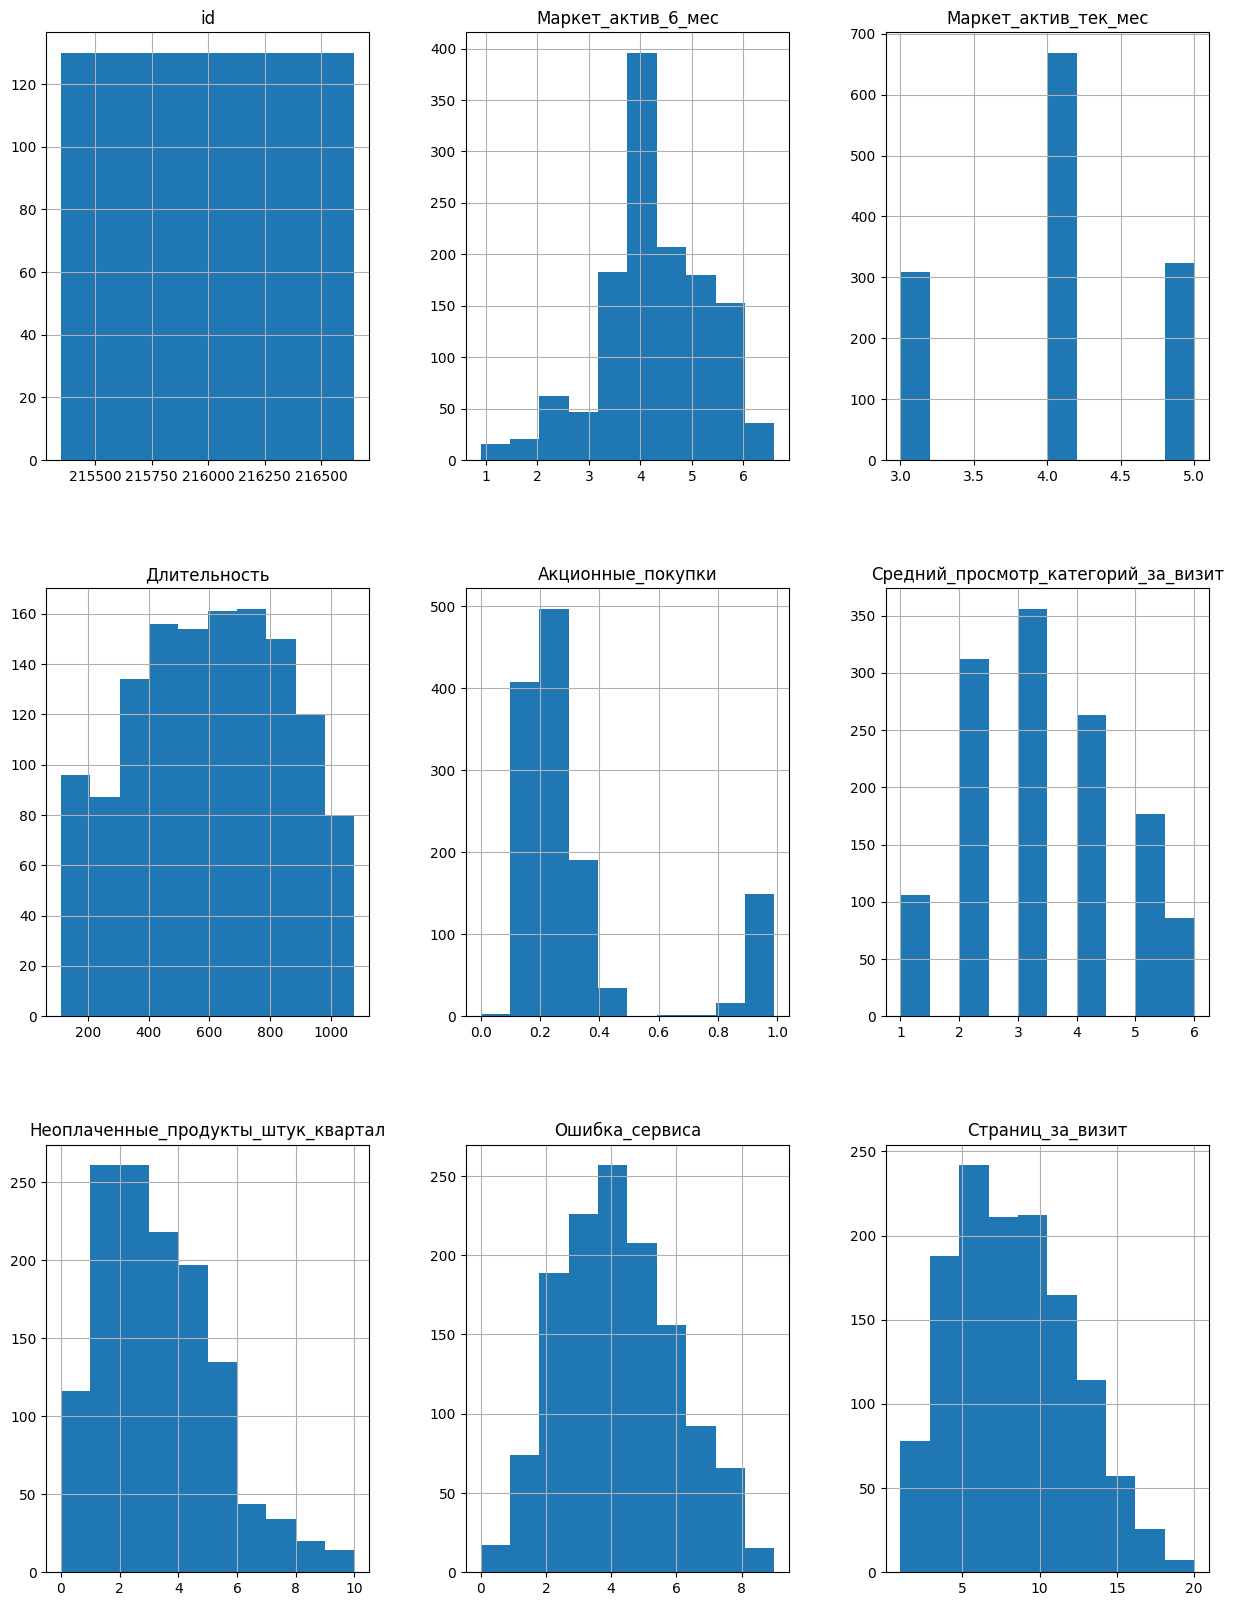

In [123]:
df_main.select_dtypes(include='number').hist(figsize=(15, 20))
print()

**No unusual long tails or abnormally high values in the distributions, promo purchases can be split into two categories, let's look at the features in more detail.**

#### Marketing_activity_6_months

In [124]:
df_main['Маркет_актив_6_мес'].describe()

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: Маркет_актив_6_мес, dtype: float64

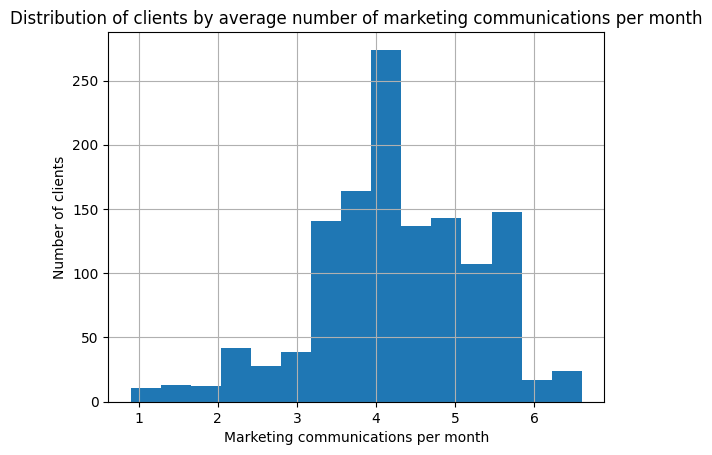

In [125]:
plt.ylabel('Number of clients')
plt.xlabel('Marketing communications per month')
plt.title('Distribution of clients by average number of marketing communications per month')
df_main['Маркет_актив_6_мес'].hist(bins=15)
print()

**On average, clients receive 4.2 communications per month, with a clear peak at 4.**

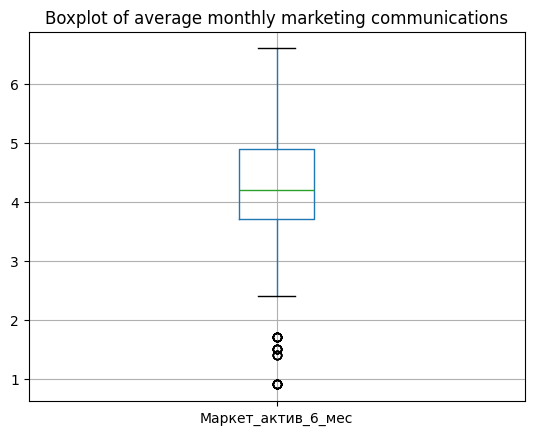

In [126]:
plt.title('Boxplot of average monthly marketing communications')
df_main.boxplot(column='Маркет_актив_6_мес')
print()

**According to the interquartile rule, there are outliers in the distribution, some users receive communications rarely (1 or less per month), shown by a small left tail.**

#### Marketing_activity_current_month

In [127]:
df_main['Маркет_актив_тек_мес'].describe()

count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: Маркет_актив_тек_мес, dtype: float64

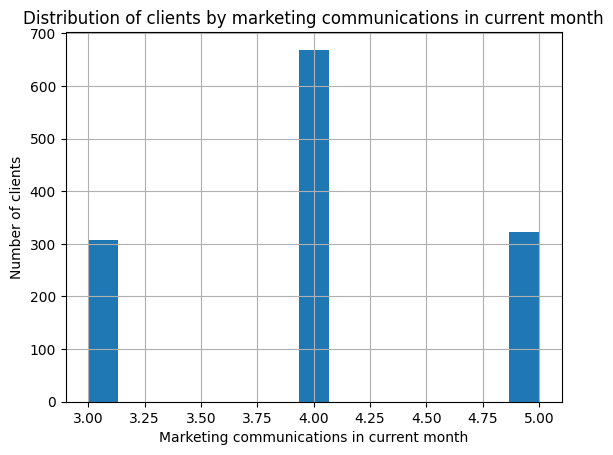

In [128]:
plt.ylabel('Number of clients')
plt.xlabel('Marketing communications in current month')
plt.title('Distribution of clients by marketing communications in current month')
df_main['Маркет_актив_тек_мес'].hist(bins=15)
print()

**Discrete numerical feature, clients receive 3 to 5 communications in the current month, median is 4.**

#### Avg_categories_per_visit

In [129]:
df_main['Средний_просмотр_категорий_за_визит'].describe()

count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: Средний_просмотр_категорий_за_визит, dtype: float64

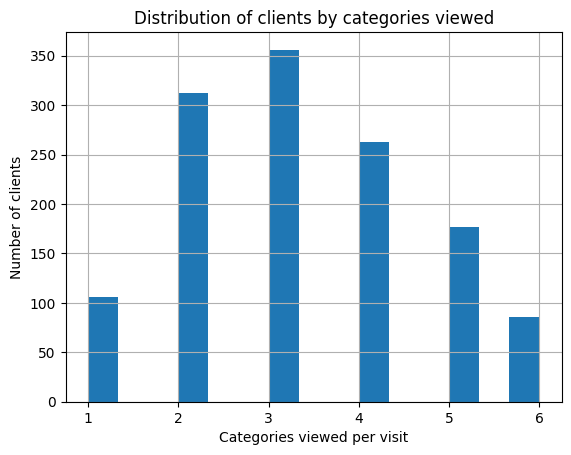

In [130]:
plt.ylabel('Number of clients')
plt.xlabel('Categories viewed per visit')
plt.title('Distribution of clients by categories viewed')
df_main['Средний_просмотр_категорий_за_визит'].hist(bins=15)
print()

**Discrete numerical feature, median categories viewed per visit is 3.**

#### Duration

In [131]:
df_main['Длительность'].describe()

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: Длительность, dtype: float64

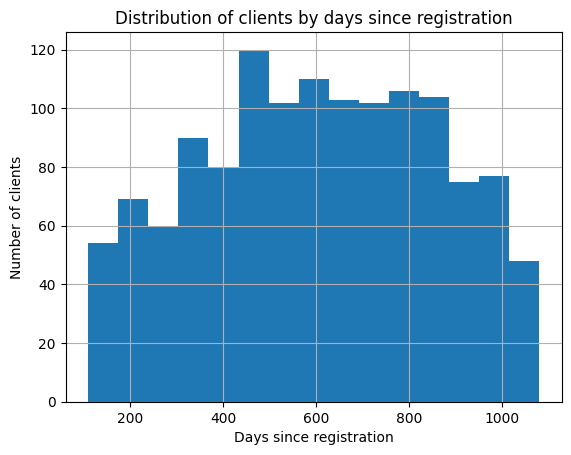

In [132]:
plt.ylabel('Number of clients')
plt.xlabel('Days since registration')
plt.title('Distribution of clients by days since registration')
df_main['Длительность'].hist(bins=15)
print()

**Since data for the last 3 months is important, it's logical that all clients registered no earlier than 110 days ago, with the oldest client using the store for almost 3 years (1079 days), and the influx of new clients is decreasing.**

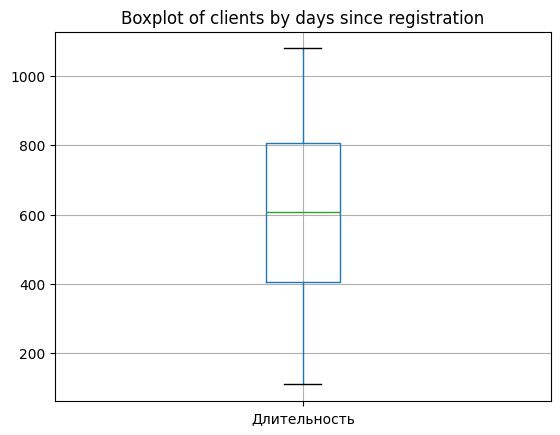

In [133]:
plt.title('Boxplot of clients by days since registration')
df_main.boxplot(column='Длительность')
print()

**Nothing strange, median is 609 days since registration.**    

#### Promo_purchases

In [134]:
df_main['Акционные_покупки'].describe()

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: Акционные_покупки, dtype: float64

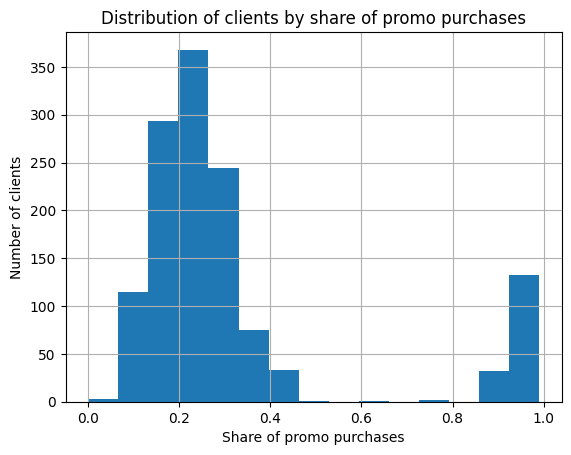

In [135]:
plt.ylabel('Number of clients')
plt.xlabel('Share of promo purchases')
plt.title('Distribution of clients by share of promo purchases')
df_main['Акционные_покупки'].hist(bins=15)
print()

**This feature can be split into two areas: share <0.6 and >0.6, will convert to categorical later. Some people buy only promo items.**

#### Unpaid_products_quarter

In [136]:
df_main['Неоплаченные_продукты_штук_квартал'].describe()

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: Неоплаченные_продукты_штук_квартал, dtype: float64

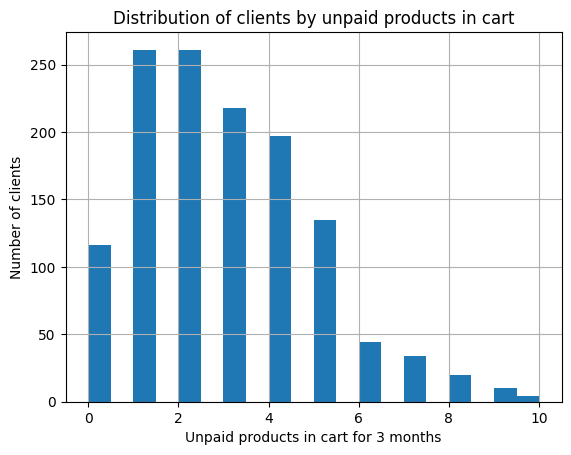

In [137]:
plt.ylabel('Number of clients')
plt.xlabel('Unpaid products in cart for 3 months')
plt.title('Distribution of clients by unpaid products in cart')
df_main['Неоплаченные_продукты_штук_квартал'].hist(bins=20)
print()

**Discrete numerical feature, median is 3 unpaid products in cart per quarter.**

#### Service_error

In [138]:
df_main['Ошибка_сервиса'].describe()

count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: Ошибка_сервиса, dtype: float64

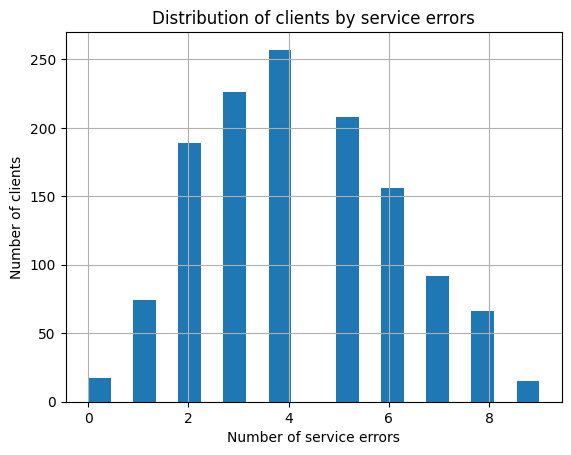

In [139]:
plt.ylabel('Number of clients')
plt.xlabel('Number of service errors')
plt.title('Distribution of clients by service errors')
df_main['Ошибка_сервиса'].hist(bins=20)
print()

**Discrete numerical feature, distribution is close to normal, median is 4.**

#### Pages_per_visit

In [140]:
df_main['Страниц_за_визит'].describe()

count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: Страниц_за_визит, dtype: float64

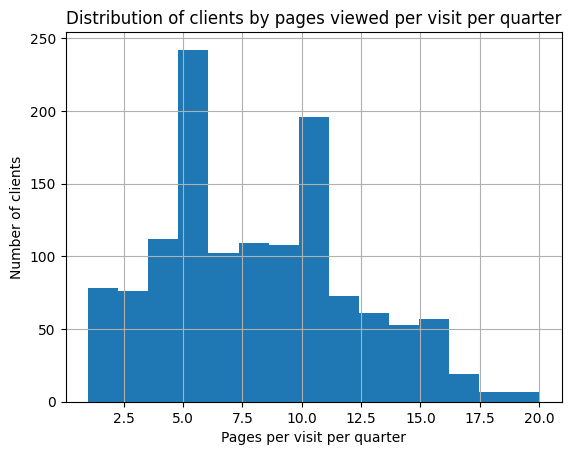

In [141]:
plt.ylabel('Number of clients')
plt.xlabel('Pages per visit per quarter')
plt.title('Distribution of clients by pages viewed per visit per quarter')
df_main['Страниц_за_визит'].hist(bins=15)
print()

**Distribution has two peaks at 5 and 10 pages viewed, median is 8.**

**Now let's look at categorical features.**

#### Categorical features.

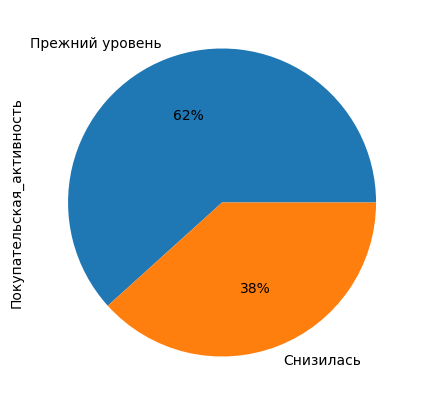

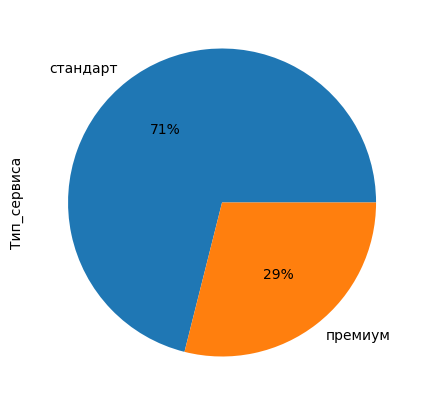

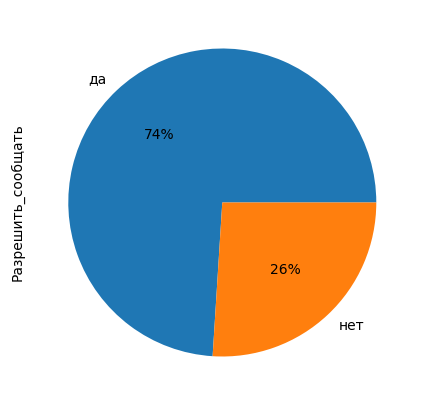

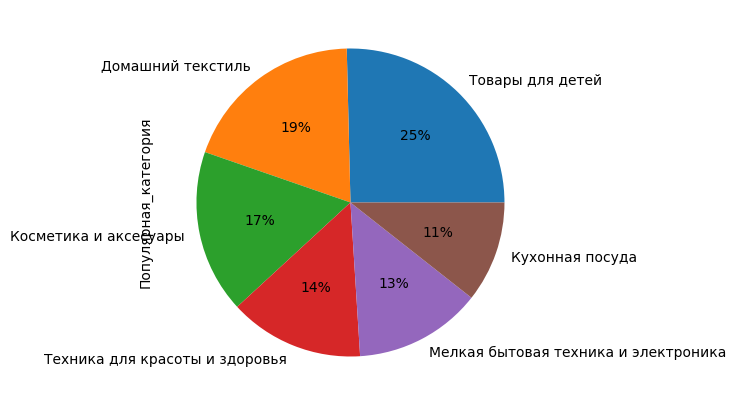

In [142]:
category_names = list(df_main.select_dtypes(include='object').columns)
for name in category_names:
    plt.figure(figsize=(5,5))
    df_main.groupby(name)[name].count().sort_values(ascending=False).plot(
    kind='pie',
    autopct='%1.0f%%'
    )


**Summary of categorical feature analysis:**
   * Target feature "customer activity" is distributed 62/38, with a 24% difference, no significant class imbalance.
   * Only 29% of clients use premium service.
   * 74% of clients allow notifications, 26% do not.
   * The most popular category is "children's goods", followed by "home textiles", then "cosmetics and accessories".

### df_market_money

#### Revenue

**Let's reshape the dataframe to have a column for revenue for each of the last three months, then look at their distributions.**

In [143]:
df_cur_month =(
    df_market_money.
    query("Период == 'текущий_месяц'")[['id', 'Выручка']].
    rename(columns={'Выручка': 'Выручка_текущ'}).
    set_index('id', drop=True)
)
df_cur_month.head()

,Выручка_текущ
id,
215348,3293.1
215349,4971.6
215350,5058.4
215351,6610.4
215352,5872.5


In [144]:
df_last_month =(
    df_market_money.
    query("Период == 'предыдущий_месяц'")[['id', 'Выручка']].
    rename(columns={'Выручка': 'Выручка_пред'}).
    set_index('id', drop=True)
)
df_last_month.shape

(1300, 1)

In [145]:
df_last_last_month =(
    df_market_money.
    query("Период == 'препредыдущий_месяц'")[['id', 'Выручка']].
    rename(columns={'Выручка': 'Выручка_препред'}).
    set_index('id', drop=True)
)
df_last_last_month.shape

(1300, 1)

In [146]:
df_market_money_new = df_cur_month.join([df_last_month, df_last_last_month])
df_market_money_new

,Выручка_текущ,Выручка_пред,Выручка_препред
id,,,
215348,3293.1,0.0,0.0
215349,4971.6,5216.0,4472.0
215350,5058.4,5457.5,4826.0
215351,6610.4,6158.0,4793.0
215352,5872.5,5807.5,4594.0
...,...,...,...
216643,4741.7,3664.0,4704.0
216644,5353.0,4729.0,5299.0
216645,5139.2,5160.0,5334.0


In [147]:
df_market_money_new.describe()

,Выручка_текущ,Выручка_пред,Выручка_препред
count,1300.000000,1300.000000,1300.000000
mean,5314.960846,4936.920385,4825.206923
std,2939.708156,739.597997,405.979663
min,2758.700000,0.000000,0.000000
25%,4706.050000,4496.750000,4583.000000
50%,5179.950000,5005.000000,4809.000000
75%,5761.725000,5405.625000,5053.500000
max,106862.200000,6869.500000,5663.000000


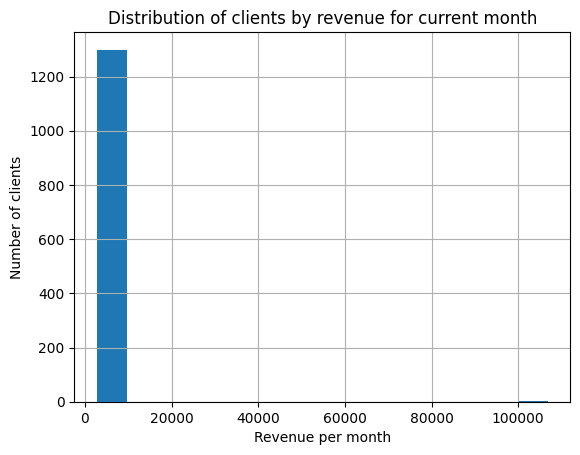

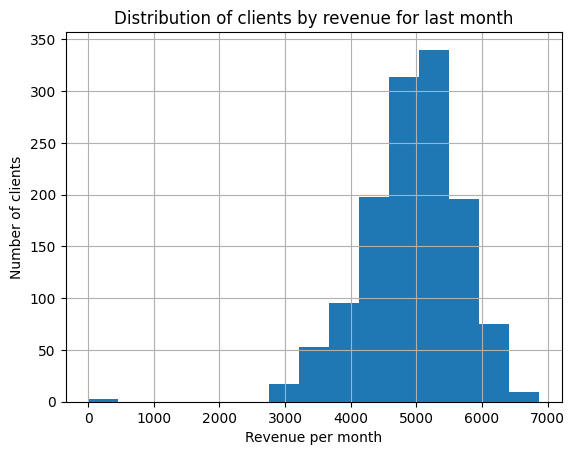

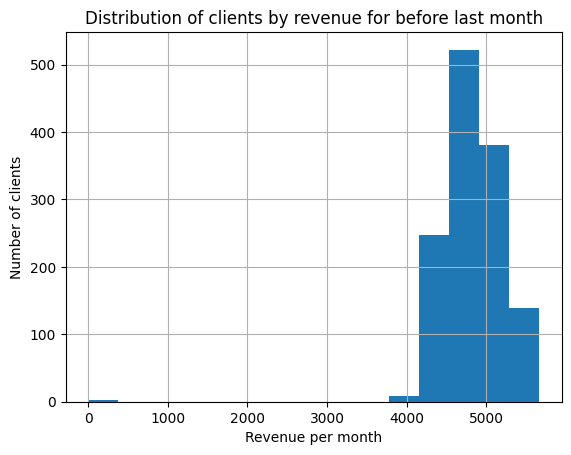

In [148]:
month_arr = ['current', 'last', 'before last']
for index, col in enumerate(df_market_money_new.columns):
    plt.ylabel('Number of clients')
    plt.xlabel('Revenue per month')
    plt.title(f'Distribution of clients by revenue for {month_arr[index]} month')
    df_market_money_new[col].hist(bins=15)
    plt.show()
    print()

**There is an abnormally large value in the current month's revenue, let's study it in detail, then look at the zero profit values for the last and before last months, which shift the distributions.**

In [149]:
df_market_money_new.sort_values(by='Выручка_текущ', ascending=False).head()

,Выручка_текущ,Выручка_пред,Выручка_препред
id,,,
215380,106862.2,6077.0,5051.0
215493,7799.4,6716.5,4870.0
215435,7605.3,6869.5,5008.0
215841,7557.0,6588.5,5621.0
216144,7547.8,6337.5,5091.0


**Only one client has such an unrealistically high revenue, let's study this client in detail.**

In [150]:
df_market_money_new.loc[215380]

Выручка_текущ      106862.2
Выручка_пред         6077.0
Выручка_препред      5051.0
Name: 215380, dtype: float64

**Replace the abnormal value with the median for this period.**

In [151]:
cur_month_median = df_market_money_new['Выручка_текущ'].median()
cur_month_median

5179.950000000001

<!-- Removed reviewer comment block -->

In [152]:
df_market_money_new['Выручка_текущ'] = df_market_money_new['Выручка_текущ'].replace(
    df_market_money_new.loc[215380]['Выручка_текущ'], cur_month_median)

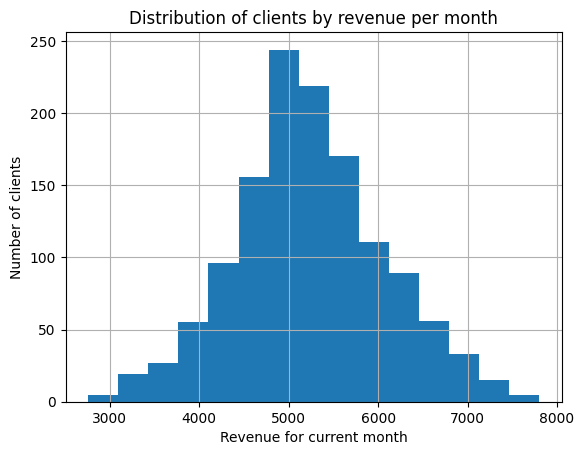

In [153]:
plt.ylabel('Number of clients')
plt.xlabel('Revenue for current month')
plt.title('Distribution of clients by revenue per month')
df_market_money_new['Выручка_текущ'].hist(bins=15)
print()

**Current month distribution is close to normal, with a peak around 5000.**

**Next, let's look at zero profit values for the last and before last months.**

In [154]:
df_market_money_new.query("Выручка_пред == 0 or Выручка_препред == 0")

,Выручка_текущ,Выручка_пред,Выручка_препред
id,,,
215348,3293.1,0.0,0.0
215357,5986.3,0.0,0.0
215359,4735.0,0.0,0.0


**All three clients have no purchases in the first two months.**

In [155]:
bad_idx = df_market_money_new.query("Выручка_пред == 0 or Выручка_препред == 0").index
df_main[df_main['id'].isin(bad_idx.values)]

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5
9,215357,Снизилась,стандарт,да,3.9,5,154,0.0,Техника для красоты и здоровья,3,3,9,5
11,215359,Снизилась,стандарт,да,4.6,5,110,0.0,Домашний текстиль,4,2,4,2


**Clients have been registered for more than three months, one has "premium" service, we won't delete them, just look at the shifted distributions.**

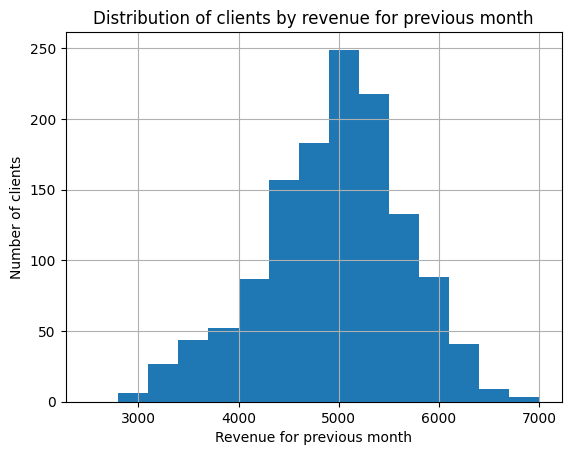

In [156]:
plt.ylabel('Number of clients')
plt.xlabel('Revenue for previous month')
plt.title('Distribution of clients by revenue for previous month')
df_market_money_new['Выручка_пред'].hist(bins=15, range=(2500, 7000))
print()

**Last month's distribution is close to normal, with a peak around 5000.**

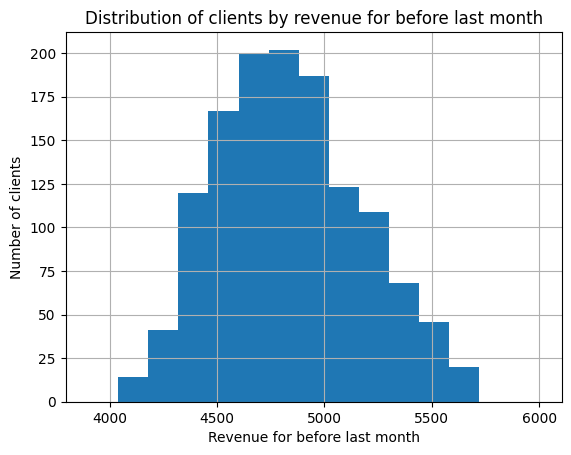

In [157]:
plt.ylabel('Number of clients')
plt.xlabel('Revenue for before last month')
plt.title('Distribution of clients by revenue for before last month')
df_market_money_new['Выручка_препред'].hist(bins=15, range=(3900, 6000))
print()

**Distribution has a smaller range compared to the next two months, more tightly grouped, median is also lower: 4800.**

### df_market_time

**Let's also create a new dataframe with columns split by period for the "minutes" feature.**

In [158]:
df_cur_month =(
    df_market_time.
    query("Период == 'текущий_месяц'")[['id', 'минут']].
    rename(columns={'минут': 'Минут_текущ'}).
    set_index('id', drop=True)
)
df_cur_month.head()

,Минут_текущ
id,
215348,14
215349,10
215350,13
215351,13
215352,11


In [159]:
df_last_month =(
    df_market_time.
    query("Период == 'предыдущий_месяц'")[['id', 'минут']].
    rename(columns={'минут': 'Минут_пред'}).
    set_index('id', drop=True)
)
df_last_month.shape

(1300, 1)

In [160]:
df_market_time_new = df_cur_month.join(df_last_month)
df_market_time_new

,Минут_текущ,Минут_пред
id,,
215348,14,13
215349,10,12
215350,13,8
215351,13,11
215352,11,8
...,...,...
216643,7,14
216644,11,12
216645,18,12


In [161]:
df_market_time_new.describe()

,Минут_текущ,Минут_пред
count,1300.000000,1300.000000
mean,13.204615,13.467692
std,4.220589,3.932029
min,4.000000,5.000000
25%,10.000000,11.000000
50%,13.000000,13.000000
75%,16.000000,17.000000
max,23.000000,23.000000


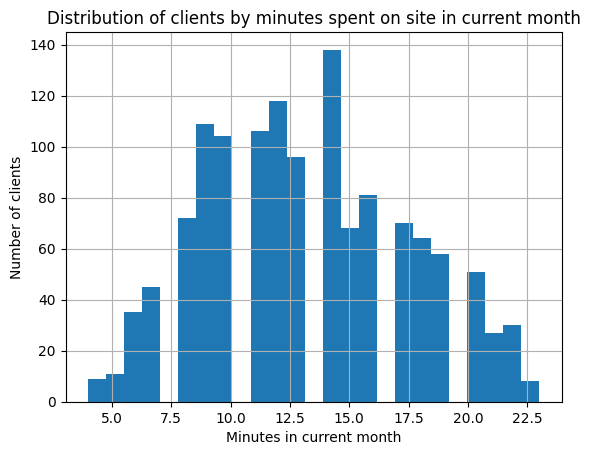

In [162]:
plt.ylabel('Number of clients')
plt.xlabel('Minutes in current month')
plt.title('Distribution of clients by minutes spent on site in current month')
df_market_time_new['Минут_текущ'].hist(bins=25)
print()

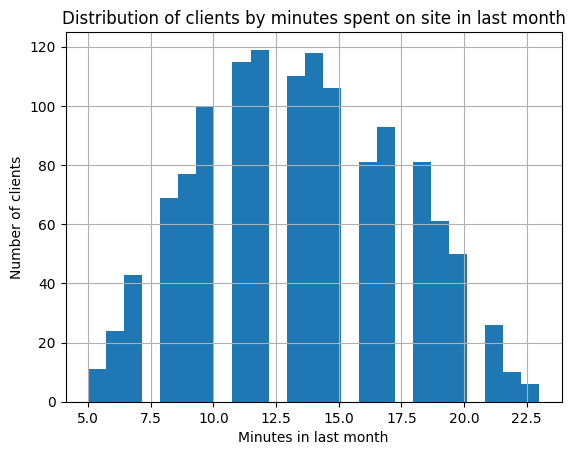

In [163]:
plt.ylabel('Number of clients')
plt.xlabel('Minutes in last month')
plt.title('Distribution of clients by minutes spent on site in last month')
df_market_time_new['Минут_пред'].hist(bins=25)
print()

**Nothing unusual in these distributions.**

### df_money

In [164]:
df_money['Прибыль'].describe()

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: Прибыль, dtype: float64

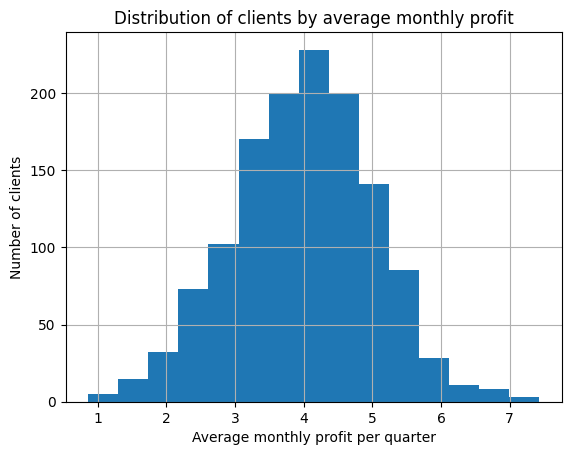

In [165]:
plt.ylabel('Number of clients')
plt.xlabel('Average monthly profit per quarter')
plt.title('Distribution of clients by average monthly profit')
df_money['Прибыль'].hist(bins=15)
print()

**Distribution is close to normal, median profit is 4 units.**

**Conclusions from exploratory data analysis:**

   * The "Promo_purchases" feature in df_main can be converted to categorical, as the histogram clearly shows two value zones.
   * Target feature "customer activity" is distributed 62/38, with a 24% difference, no significant class imbalance.
   * Only 29% of clients use premium service.
   * 74% of clients allow notifications, 26% do not.
   * The most popular category is "children's goods", followed by "home textiles", then "cosmetics and accessories".
   

<!-- Removed reviewer comment block -->

## Merging tables

**We will merge all three tables by the id feature, which we will set as the dataframe index. In df_market_time_new and df_market_money_new, the features have already been split by period and id set as index.**

In [166]:
df_main.set_index('id', drop=True, inplace=True)
df_money.set_index('id', drop=True, inplace=True)
df_main.head()

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
id,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [167]:
df_main.shape

(1300, 12)

In [168]:
df_main = df_main.join([df_market_money_new, df_market_time_new])

In [169]:
df_main

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущ,Выручка_пред,Выручка_препред,Минут_текущ,Минут_пред
id,,,,,,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,3293.1,0.0,0.0,14,13
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,4472.0,10,12
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,4826.0,13,8
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,4793.0,13,11
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,5807.5,4594.0,11,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,4741.7,3664.0,4704.0,7,14
216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,5353.0,4729.0,5299.0,11,12
216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5139.2,5160.0,5334.0,18,12


In [170]:
bad_idx.values

array([215348, 215357, 215359], dtype=int64)

In [171]:
df_main.drop(bad_idx.values, inplace=True)
df_money.drop(bad_idx.values, inplace=True)
df_main.head()

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущ,Выручка_пред,Выручка_препред,Минут_текущ,Минут_пред
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,4472.0,10,12
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,4826.0,13,8
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,4793.0,13,11
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,5807.5,4594.0,11,8
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5388.5,4738.5,5124.0,10,10


In [172]:
df_main.shape

(1297, 17)

**All three tables successfully merged, five new features added to df_main, shape check shows no contradictions.**

## Correlation analysis

**For quantitative features, let's build a heatmap of correlation coefficients between them.**

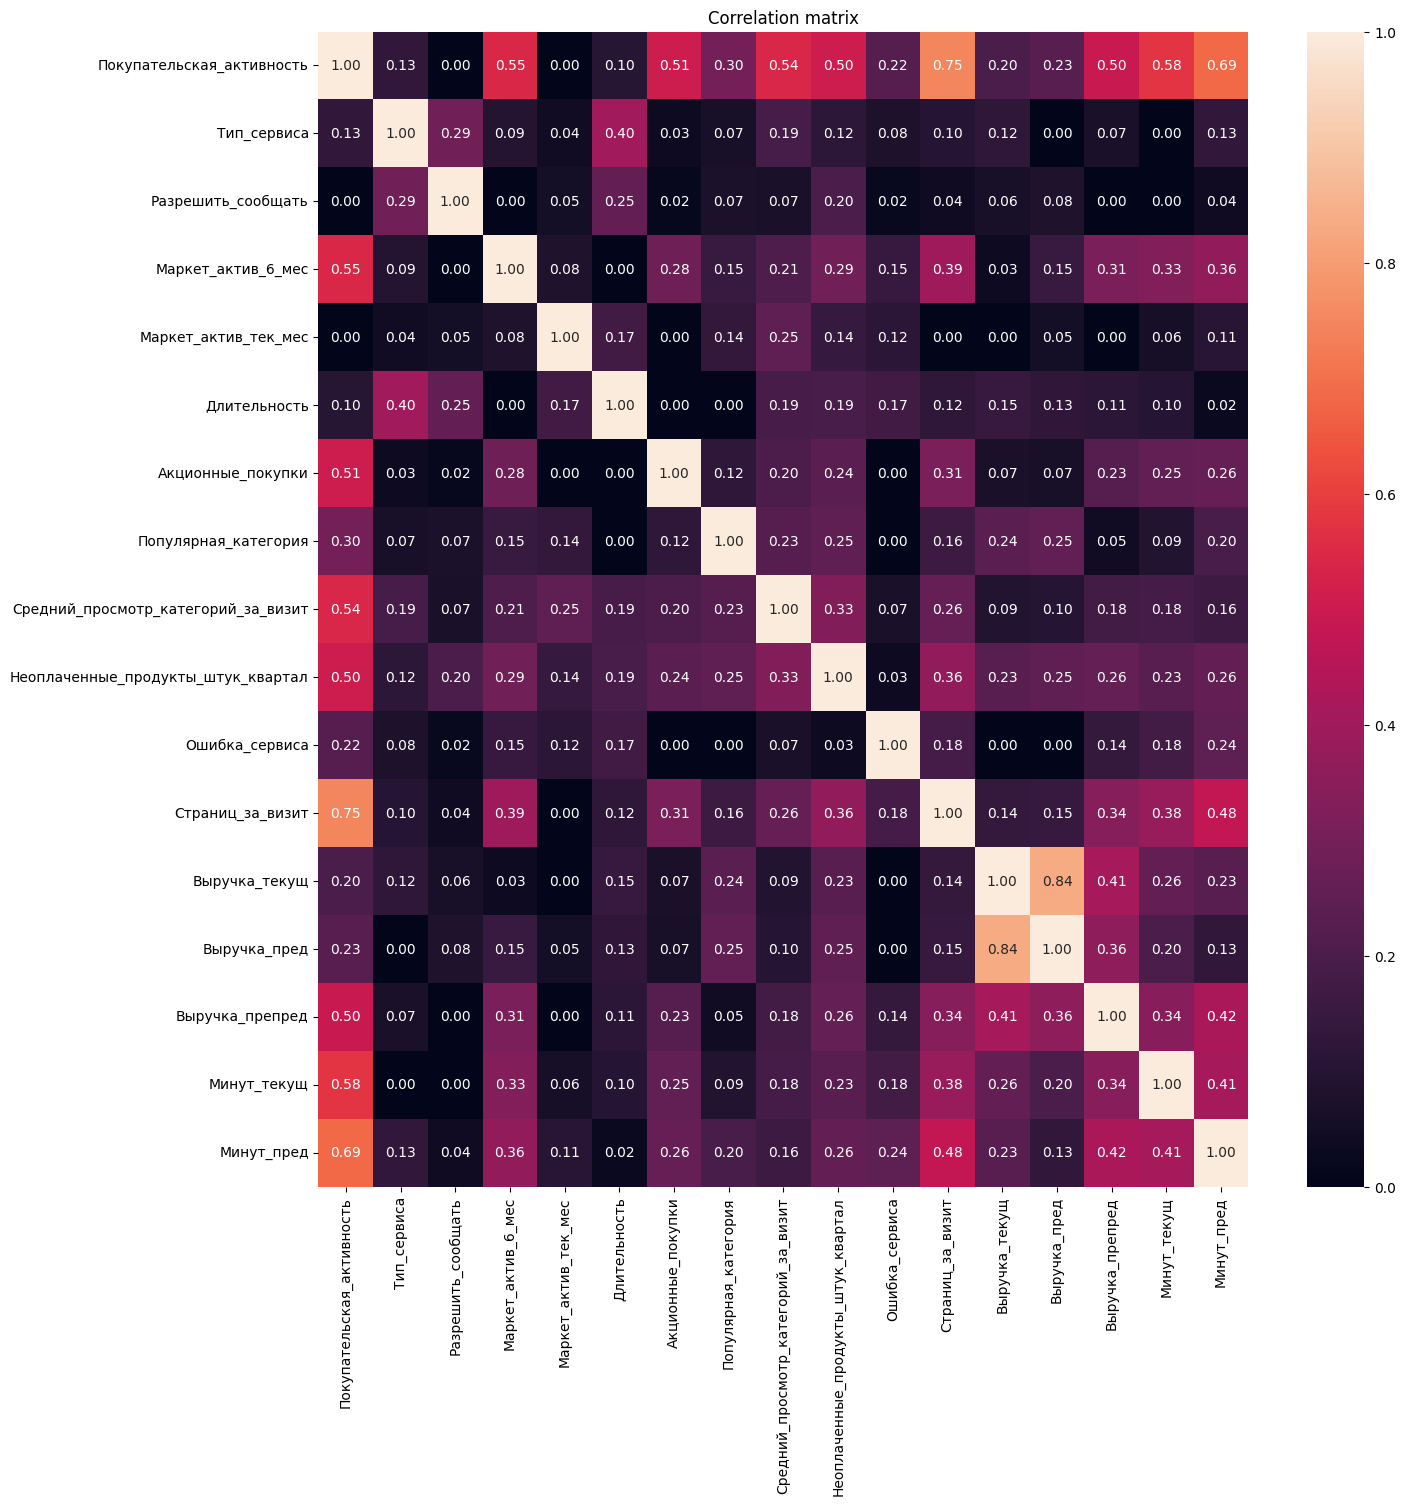

In [173]:
interval_cols = df_main.select_dtypes(include='number').columns.tolist()
fig, ax = plt.subplots(figsize=(15,15))
plt.title('Correlation matrix')
sns.heatmap(df_main.phik_matrix(interval_cols=interval_cols),
            annot=True, 
            fmt='.2f',
            ax=ax) 
print()

In [174]:
phik_df = df_main.phik_matrix(interval_cols=interval_cols)

**Let's look at feature correlations above 0.5.**

In [175]:
phik_filtered = phik_df.where((phik_df > 0.5)).stack().index.to_list()
corr_dict = {}
for elem in phik_filtered:
    if (elem[0] != elem[1]) & (elem[::-1] not in corr_dict.keys()):
        corr_dict[elem] = phik_df.loc[elem]
pd.Series(corr_dict).sort_values(ascending=False)

Выручка_текущ              Выручка_пред                           0.835654
Покупательская_активность  Страниц_за_визит                       0.748769
                           Минут_пред                             0.685078
                           Минут_текущ                            0.575662
                           Маркет_актив_6_мес                     0.546370
                           Средний_просмотр_категорий_за_визит    0.539221
                           Акционные_покупки                      0.506991
                           Неоплаченные_продукты_штук_квартал     0.504845
dtype: float64

**The highest correlation is between "Promo purchases" - "Revenue_before_last", "Promo purchases" - "Revenue_last", "Revenue_last" - "Revenue_before_last", "Revenue_current" - "Revenue_last". It's logical that the amount of promo purchases affects store revenue, and that revenue from a regular customer correlates across months.**

In [176]:
phik_df['Покупательская_активность'].sort_values(ascending=False)

Покупательская_активность              1.000000
Страниц_за_визит                       0.748769
Минут_пред                             0.685078
Минут_текущ                            0.575662
Маркет_актив_6_мес                     0.546370
Средний_просмотр_категорий_за_визит    0.539221
Акционные_покупки                      0.506991
Неоплаченные_продукты_штук_квартал     0.504845
Выручка_препред                        0.495174
Популярная_категория                   0.298036
Выручка_пред                           0.227280
Ошибка_сервиса                         0.223697
Выручка_текущ                          0.195470
Тип_сервиса                            0.132247
Длительность                           0.101767
Маркет_актив_тек_мес                   0.000000
Разрешить_сообщать                     0.000000
Name: Покупательская_активность, dtype: float64

**The strongest correlation of the target with features: "Pages_per_visit", "Minutes_last", "Minutes_current", and "Marketing_activity_6_months".**

**No multicollinearity detected (usually corresponds to correlation coefficients 0.9 and above).**

<!-- Removed reviewer comment block -->

<!-- Removed reviewer comment block -->

## Using pipelines

**First, let's form feature categories: split qualitative into ordinal and binary for encoding, and select numerical features for scaling. Also, convert the quantitative "Promo_purchases" to binary with a threshold of 0.6, as seen in its distribution. Also, replace target values.**

In [177]:
df_main['Акционные_покупки_бин'] = df_main['Акционные_покупки'] >= 0.6
df_main.head()

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущ,Выручка_пред,Выручка_препред,Минут_текущ,Минут_пред,Акционные_покупки_бин
id,,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,4472.0,10,12,True
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,4826.0,13,8,False
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,4793.0,13,11,True
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,5807.5,4594.0,11,8,True
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5388.5,4738.5,5124.0,10,10,False


**Replace target values: "Decreased" - "1", "Previous level": - "0".**

In [178]:
original_classes = ['Не снизилась', 'Снизилась']

lab_encoder = LabelEncoder()
lab_encoder.classes = np.array(original_classes)

df_main['Покупательская_активность'] = lab_encoder.fit_transform(df_main['Покупательская_активность'])
df_main.head()

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущ,Выручка_пред,Выручка_препред,Минут_текущ,Минут_пред,Акционные_покупки_бин
id,,,,,,,,,,,,,,,,,,
215349,1,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,4472.0,10,12,True
215350,1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,4826.0,13,8,False
215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,4793.0,13,11,True
215352,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,5807.5,4594.0,11,8,True
215353,1,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5388.5,4738.5,5124.0,10,10,False


In [179]:
df_main.select_dtypes(exclude='number').columns

Index(['Тип_сервиса', 'Разрешить_сообщать', 'Популярная_категория',
       'Акционные_покупки_бин'],
      dtype='object')

**Features "Service_type", "Allow_notifications", "Promo_purchases_bin" are encoded with OHE, they are binary, "Popular_category" is nominal, encoded with OrdinalEncoder.**

In [180]:
df_main.select_dtypes(include='number').columns

Index(['Покупательская_активность', 'Маркет_актив_6_мес',
       'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'Выручка_текущ', 'Выручка_пред', 'Выручка_препред',
       'Минут_текущ', 'Минут_пред'],
      dtype='object')

**All numerical features except "Customer_activity" (target) and "Promo_purchases" (replaced with binary) are scaled using StandardScaler and MinMaxScaler in pipeline parameter search.**

In [181]:
X_train, X_test, y_train, y_test = train_test_split(
    df_main.drop(['Покупательская_активность','Акционные_покупки'], axis=1),
    df_main['Покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_main['Покупательская_активность'])

X_train.shape, X_test.shape

((972, 16), (325, 16))

In [182]:
ohe_columns = ['Тип_сервиса', 'Разрешить_сообщать', 'Акционные_покупки_бин', 'Популярная_категория']
num_columns = [
       'Маркет_актив_6_мес',
       'Маркет_актив_тек_мес', 'Длительность',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'Выручка_текущ', 'Выручка_пред', 'Выручка_препред',
       'Минут_текущ', 'Минут_пред']

**Start creating pipelines for scaling and encoding.**

In [183]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False))
    ]
    )

#ord_pipe = Pipeline(
    #[('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     #('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
    # ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
   # ]
#)

**Combine pipelines for feature processing.**

In [184]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     #('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

**Create the final pipeline.**

In [185]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

**Create a dictionary with models and hyperparameters for search.**

In [186]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 7),
        'models__max_features': range(2, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            solver='liblinear', 
            penalty='l1',
            random_state=RANDOM_STATE, 
        )],
        'models__C': [0.001, 0.01, 0.1, 1, 2, 5, 10, 100],
        'models__penalty': ['l1', 'l2'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    
    # словарь для модели SVC()
    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            probability=True
        )],
        'models__C': [0.001, 0.01, 0.1, 1, 2, 5, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
    
]


**In this task, it is important to correctly classify all clients whose activity decreased, and also avoid false positives, as sending promos to everyone would cost the store money. Both recall and precision are important, so we use ROC-AUC scoring.**

<!-- Removed reviewer comment block -->

In [187]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    scoring='roc_auc',
    cv=5,
    n_iter=50,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse_output=False))]),
                                                                               ['Тип_сервиса',
                                                                                'Разрешить_сообщать',
                                                                                'Акционные_покупки_бин',
                                                                                'Популярная_категория']),...
                                                                       solver='liblinear')],
                                         'models__C': [0.001, 0.01, 0.1, 1, 2,
                                                       5, 10, 100],
                                         'models__penalty': ['l1', 'l2'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(probability=True,
                                                        random_state=44)],
                                         'models__C': [0.001, 0.01, 0.1, 1, 2,
                                                       5, 10, 100],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=44, scoring='roc_auc')

<!-- Removed reviewer comment block -->

In [188]:
print('Best model and its parameters:\n\n', randomized_search.best_estimator_)
print ('Best model metric on validation set:', randomized_search.best_score_)

Best model and its parameters:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['Тип_сервиса',
                                                   'Разрешить_сообщать',
                                                   'Акционные_покупки_бин',
                                                   'Популярная_категория']),
                                                 ('nu

**Note: .best_score_ is the metric on the cross-validation set, not the training set. We do not select the best model by training set results, as it does not show generalization.**

In [189]:
y_test_pred_proba = randomized_search.predict_proba(X_test)[:, 1]
print(f'ROC-AUC metric on test set: {roc_auc_score(y_test, y_test_pred_proba)}')

ROC-AUC metric on test set: 0.9024434280211844


<!-- Removed reviewer comment block -->

**We got a good ROC-AUC = 0.906 for the test set, now let's see how other models performed.**

In [190]:
pd.set_option('display.max_colwidth', 200)
result = pd.DataFrame(randomized_search.cv_results_)
result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score').head(15)

,rank_test_score,param_models,mean_test_score,params
32,1,"SVC(probability=True, random_state=44)",0.912714,"{'preprocessor__num': StandardScaler(), 'models__C': 5, 'models': SVC(probability=True, random_state=44)}"
42,2,"SVC(probability=True, random_state=44)",0.908600,"{'preprocessor__num': StandardScaler(), 'models__C': 0.1, 'models': SVC(probability=True, random_state=44)}"
9,3,"SVC(probability=True, random_state=44)",0.908199,"{'preprocessor__num': MinMaxScaler(), 'models__C': 0.1, 'models': SVC(probability=True, random_state=44)}"
30,4,"SVC(probability=True, random_state=44)",0.908156,"{'preprocessor__num': MinMaxScaler(), 'models__C': 1, 'models': SVC(probability=True, random_state=44)}"
47,5,"SVC(probability=True, random_state=44)",0.907462,"{'preprocessor__num': StandardScaler(), 'models__C': 0.01, 'models': SVC(probability=True, random_state=44)}"
10,6,"SVC(probability=True, random_state=44)",0.905090,"{'preprocessor__num': MinMaxScaler(), 'models__C': 0.01, 'models': SVC(probability=True, random_state=44)}"
18,7,"LogisticRegression(penalty='l1', random_state=44, solver='liblinear')",0.904788,"{'preprocessor__num': MinMaxScaler(), 'models__penalty': 'l2', 'models__C': 5, 'models': LogisticRegression(penalty='l1', random_state=44, solver='liblinear')}"
33,8,"LogisticRegression(penalty='l1', random_state=44, solver='liblinear')",0.904215,"{'preprocessor__num': MinMaxScaler(), 'models__penalty': 'l2', 'models__C': 1, 'models': LogisticRegression(penalty='l1', random_state=44, solver='liblinear')}"
48,9,"LogisticRegression(penalty='l1', random_state=44, solver='liblinear')",0.903774,"{'preprocessor__num': MinMaxScaler(), 'models__penalty': 'l1', 'models__C': 10, 'models': LogisticRegression(penalty='l1', random_state=44, solver='liblinear')}"
11,10,"LogisticRegression(penalty='l1', random_state=44, solver='liblinear')",0.903727,"{'preprocessor__num': StandardScaler(), 'models__penalty': 'l2', 'models__C': 1, 'models': LogisticRegression(penalty='l1', random_state=44, solver='liblinear')}"


**As we can see, SVC (C = 5) and KNN (n_neighbors = 6) with StandardScaler scaling solve this classification task best.**

## Feature importance analysis

**Since SVC coefficients are not interpretable (define a hyperplane), and KNN just stores the training set, we will estimate feature importance using SHAP values on the best logistic regression result (C=10, penalty='l1', solver='liblinear').**

<!-- Removed reviewer comment block -->

**Initialize the model with the best parameters and prepare data for it.**

In [191]:
oh_encoder = OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False)
oh_encoder.fit(X_train[ohe_columns])
encoder_col_names = oh_encoder.get_feature_names_out()

X_train[encoder_col_names] = oh_encoder.transform(X_train[ohe_columns])
X_test[encoder_col_names] = oh_encoder.transform(X_test[ohe_columns])

X_train = X_train.drop(ohe_columns, axis=1)
X_test = X_test.drop(ohe_columns, axis=1)

scaler = MinMaxScaler()

X_train[num_columns] = scaler.fit_transform(X_train[num_columns])
X_test[num_columns] = scaler.transform(X_test[num_columns])

In [192]:
X_train.rename(columns={'x2_True': 'Promo_sales', 
                       'x0_стандарт': 'Service_type',
                       'x1_нет': 'Disallow_notifications'}, inplace=True)

X_test.rename(columns={'x2_True': 'Promo_sales', 
                       'x0_стандарт': 'Service_type',
                       'x1_нет': 'Disallow_notifications'}, inplace=True)

In [193]:
best_model = LogisticRegression(
    penalty='l1', 
    random_state=RANDOM_STATE,
    solver='liblinear',
    C=10)
best_model.fit(X_train, y_train)

LogisticRegression(C=10, penalty='l1', random_state=44, solver='liblinear')

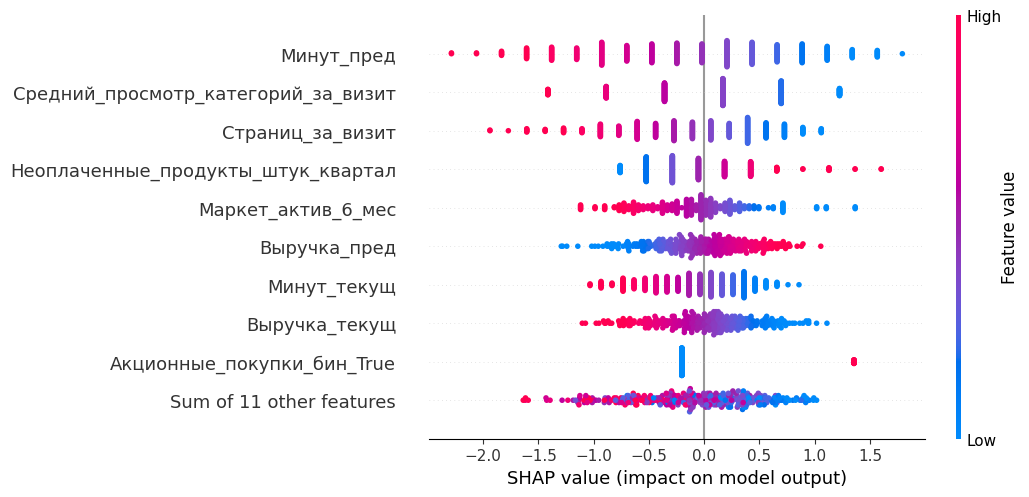

In [194]:
explainer = shap.LinearExplainer(best_model, X_test)
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values) 

<!-- Removed reviewer comment block -->

<!-- Removed reviewer comment block -->

**From this plot we can conclude:**
   * The more minutes a person spent on the site last month, the less likely their activity will decrease.
   * The more pages a person views, the less likely their activity will decrease.
   * The more unpaid products a person has, the more likely their activity will decrease.
   * The more categories viewed per visit, the more interested the person is in continuing to use the store.

**Let's see which features led to incorrect classification.**

In [195]:
X_test_df = pd.DataFrame()
X_test_df['y_test'] = y_test.tolist()
X_test_df['predict_proba'] = best_model.predict_proba(X_test)[:,1]

X_test_df[(X_test_df['y_test']==1)&(X_test_df['predict_proba']<0.3)].head()

,y_test,predict_proba
56,1,0.278836
66,1,0.134140
70,1,0.061726
91,1,0.192754
97,1,0.099845


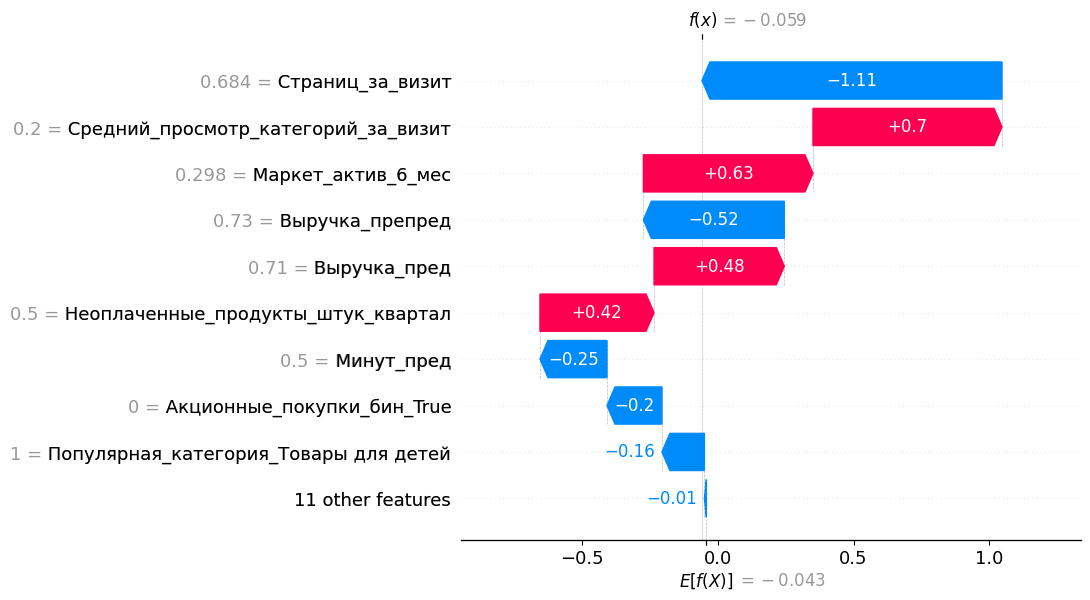

In [196]:
shap.plots.waterfall(shap_values[19])

**This client had fewer than average unpaid items in the cart, spent a lot of time on the site, and viewed many pages per visit, so it's clear why the model made a mistake, perhaps due to other circumstances.**

**Given all of the above, it is in the store's interest to keep the customer's attention on the site, as this reduces the likelihood of losing interest. It may be worth updating the site interface, adding personalized offers based on the most frequently purchased category, adding a mini-game after an order, etc. We'll select more specific solutions for particular customer segments.**

<!-- Removed reviewer comment block -->

## Customer segmentation

**First, merge the profitability data with the main dataframe.**

**Let's consider the following customer segment: customers who buy only electronics, i.e., products with a long life cycle. Select their data from the table.**

In [197]:
df_tech = df_main.query("Популярная_категория == 'Мелкая бытовая техника и электроника'")
df_tech.head()

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущ,Выручка_пред,Выручка_препред,Минут_текущ,Минут_пред,Акционные_покупки_бин
id,,,,,,,,,,,,,,,,,,
215398,1,премиум,да,3.5,5,882,0.22,Мелкая бытовая техника и электроника,3,2,6,3,5854.2,5530.5,4557.0,6,5,False
215467,1,стандарт,да,4.4,4,503,0.90,Мелкая бытовая техника и электроника,2,3,3,3,5062.3,4853.0,4367.0,13,7,True
215497,1,премиум,да,5.6,5,719,0.28,Мелкая бытовая техника и электроника,1,2,7,1,6277.1,5871.5,4475.0,5,9,False
215509,1,премиум,да,4.0,5,982,0.94,Мелкая бытовая техника и электроника,3,1,2,6,5299.3,5265.5,4880.0,6,8,True
215528,1,стандарт,да,4.4,4,773,0.98,Мелкая бытовая техника и электроника,3,3,8,6,6103.3,5270.0,4502.0,8,8,True


In [198]:
df_tech.describe()

,Покупательская_активность,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущ,Выручка_пред,Выручка_препред,Минут_текущ,Минут_пред
count,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000
mean,0.155172,4.552299,4.028736,623.810345,0.269713,3.517241,2.126437,4.333333,8.885057,5287.467241,5028.281609,4885.155172,14.275862,14.568966
std,0.363114,0.893503,0.648949,245.288561,0.209040,1.284519,1.412615,1.933380,3.559325,989.446451,633.398363,319.424092,4.197962,3.952516
min,0.000000,1.400000,3.000000,136.000000,0.110000,1.000000,0.000000,0.000000,1.000000,3237.200000,3234.000000,4258.000000,4.000000,5.000000
25%,0.000000,4.100000,4.000000,437.000000,0.160000,3.000000,1.000000,3.000000,6.000000,4527.850000,4626.375000,4644.000000,11.000000,11.000000
50%,0.000000,4.400000,4.000000,633.500000,0.225000,3.000000,2.000000,4.000000,9.000000,5266.150000,5045.250000,4865.500000,14.000000,15.000000
75%,0.000000,5.275000,4.000000,814.000000,0.280000,4.000000,3.000000,6.000000,11.000000,5969.200000,5443.875000,5124.750000,17.750000,18.000000
max,1.000000,6.600000,5.000000,1061.000000,0.990000,6.000000,5.000000,8.000000,18.000000,7557.000000,6588.500000,5663.000000,22.000000,23.000000


In [199]:
df_tech['Тип_сервиса'].value_counts()

Тип_сервиса
стандарт    127
премиум      47
Name: count, dtype: int64

**As we see from the descriptive statistics, the median days since registration for electronics buyers is 633, median revenue per month is growing, the average customer in this category buys only 20% of products on promo and visits 9 pages per visit, spending 14-15 minutes on the site. 3/4 of clients do not use premium service. The loyalty program may need improvement, as electronics buyers are usually long-term customers.**

## General conclusion

**Project goal: select the most accurate model to predict the decrease in customer activity in an online store. Based on the model and data analysis, identify customer segments and formulate personalized offers to improve customer activity.**

**The source data includes 4 datasets, detailed descriptions are at the beginning of the project.**

1. During preprocessing:
    * Typos were fixed
    * Feature values were formatted
  
2. To find the best model, a pipeline with scaling/encoding was set up and hyperparameters were selected using RandomizedSearchCV, testing 4 algorithms: logistic regression, SVC, KNN, and decision tree. ROC-AUC was used for comparison.
3. The best model was SVC with L2 regularization and standardized numerical features.
4. Since SVC is hard to interpret, the best logistic regression model was used for feature importance analysis, with these results:
    * More minutes spent on the site last month reduces the likelihood of decreased activity
    * More pages viewed reduces the likelihood of decreased activity
    * More unpaid products increases the likelihood of decreased activity
    * More categories viewed per visit increases interest in the store
    
5. The segment of electronics and appliance buyers was studied. These clients are usually long-term users, so a loyalty program with cumulative discounts is recommended (e.g., 1% permanent discount for every 10,000 spent).